In [9]:
# ## Import Libraries

# Standard Libraries
import time
import warnings

# Scientific Libraries
import numpy as np
import pandas as pd
import torch

# Sklearn
from sklearn.preprocessing import StandardScaler

# Torch Tools
from torch.utils.tensorboard import SummaryWriter

# Custom Utilities
from utils.dl_helper_functions import (
    convert_to_tensors,
    #create_sequences,
    load_picture_lagged_data,
    scale_data,
    scale_data_parallel
)

from utils.Model_Training import training_ConvLSTM_Regression_Classification
from utils.config import (PRED_COLOR, TRUE_COLOR)

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns in pandas
pd.options.display.max_columns = None

# TensorBoard writer
writer = SummaryWriter()

# Define global constants
DTYPE_NUMPY = np.float32              # Datentyp für numpy Arrays
n_jobs = 16                           # Anzahl CPUs für parallele Prozesse
HORIZON = 24                          # 1 Tag Vorhersagehorizont
SEQUENCE_LENGTH = 24                 # 1 Tag als Input-Sequenz



In [10]:
trial_name = "Versuch2"

if trial_name == "Versuch1":
    keep_ocean_data = True
elif trial_name == "Versuch2":
    keep_ocean_data = False
else:
    raise ValueError("Trial must be either 'Versuch1' or 'Versuch2'")

# Load data
X, y_lagged, y, common_time = load_picture_lagged_data(
    return_common_time=True,
    verbose=False,
    grid_size=25,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    keep_ocean_data=keep_ocean_data,
    pca=True,
    land_values=0.0,
    lags=SEQUENCE_LENGTH,
    light_mode=True
)



Dropping columns: ['snowfall', 'siconc', 'rain', 'sithick', 'precipitation', 'weather_code', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_high', 'cloud_cover_mid', 'vapour_pressure_deficit', 'et0_fao_evapotranspiration', 'relative_humidity_2m', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'mlotst', 'bottomT', 'so', 'sob', 'thetao', 'uo', 'vo', 'wo', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'weather_code', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'wind_gusts_10m']

Shapes of DataFrames after dropping columns:
Ocean DataFrame: (9415187, 4)
Weather DataFrame: (2018400, 6)
Insitu DataFrame: (20161, 2)


Interpolating sla: 100%|██████████| 20161/20161 [00:07<00:00, 2662.80it/s]


                 time  pressure_msl_PC_1  wind_u_PC_1  wind_u_PC_2  \
0 2022-12-04 00:00:00           1.527747     1.524114    -0.066490   
1 2022-12-04 01:00:00           1.515856     1.537008    -0.104939   
2 2022-12-04 02:00:00           1.504952     1.555108    -0.082270   
3 2022-12-04 03:00:00           1.492470     1.569216    -0.049048   
4 2022-12-04 04:00:00           1.490492     1.579483    -0.001507   

   wind_u_PC_3  wind_u_PC_4  wind_v_PC_1  wind_v_PC_2  wind_v_PC_3  \
0     0.918770    -0.393766     0.361408    -1.566875     0.682671   
1     0.898017    -0.388857     0.350675    -1.635676     0.556428   
2     0.916119    -0.390986     0.345677    -1.671069     0.462962   
3     0.861304    -0.342645     0.349726    -1.675735     0.440284   
4     0.800727    -0.268733     0.354728    -1.686966     0.411269   

   wind_v_PC_4  wind_v_PC_5  
0    -0.323538     0.148368  
1    -0.252010     0.091943  
2    -0.268378     0.032174  
3    -0.294276     0.067061  
4    -0.

In [11]:
df_X_features = pd.DataFrame(X, columns=[f"feature_{i+1}" for i in range(X.shape[1])])
df_X_features["time"]= common_time
df_X_features['time'] = pd.to_datetime(df_X_features['time'], unit='s')
df_X_features.set_index('time', inplace=True)

df_y_lagged = pd.DataFrame(y_lagged, columns=[f"lagged_{i+1}" for i in range(y_lagged.shape[1])])
df_y_lagged['time'] = common_time
df_y_lagged['time'] = pd.to_datetime(df_y_lagged['time'], unit='s')
df_y_lagged.set_index('time', inplace=True)

df_y = pd.DataFrame(y, columns=["target"])
df_y['time'] = common_time
df_y['time'] = pd.to_datetime(df_y['time'], unit='s')
df_y.set_index('time', inplace=True)

display(df_X_features.head())
display(df_y_lagged.head())
display(df_y.head())




# combine X_df and y_lagged_df
df_X = pd.merge(df_X_features, df_y_lagged, left_index=True, right_index=True).sort_index(ascending=True)
#df_X = pd.merge(df_X, df_y, left_index=True, right_index=True).sort_index(ascending=True)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
time,,,,,,,,,,
2022-12-04 00:00:00,1.527747,1.524114,-0.066490,0.918770,-0.393766,0.361408,-1.566875,0.682671,-0.323538,0.148368
2022-12-04 01:00:00,1.515856,1.537008,-0.104939,0.898017,-0.388857,0.350675,-1.635676,0.556428,-0.252010,0.091943
2022-12-04 02:00:00,1.504952,1.555108,-0.082270,0.916119,-0.390986,0.345677,-1.671069,0.462962,-0.268378,0.032174
2022-12-04 03:00:00,1.492470,1.569216,-0.049048,0.861304,-0.342645,0.349726,-1.675735,0.440284,-0.294276,0.067061
2022-12-04 04:00:00,1.490492,1.579483,-0.001507,0.800727,-0.268733,0.354728,-1.686966,0.411269,-0.347518,0.166676


,lagged_1,lagged_2,lagged_3,lagged_4,lagged_5,lagged_6,lagged_7,lagged_8,lagged_9,lagged_10,lagged_11,lagged_12,lagged_13,lagged_14,lagged_15,lagged_16,lagged_17,lagged_18,lagged_19,lagged_20,lagged_21,lagged_22,lagged_23,lagged_24
time,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-04 00:00:00,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563,0.487133
2022-12-04 01:00:00,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563
2022-12-04 02:00:00,0.285435,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853
2022-12-04 03:00:00,0.212980,0.285435,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051
2022-12-04 04:00:00,0.150911,0.212980,0.285435,0.344799,0.357195,0.299965,0.244428,0.207593,0.199870,0.195947,0.182835,0.151260,0.260760,0.345469,0.332200,0.337390,0.278726,0.256204,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839


,target
time,
2022-12-04 00:00:00,0.344799
2022-12-04 01:00:00,0.285435
2022-12-04 02:00:00,0.212980
2022-12-04 03:00:00,0.150911
2022-12-04 04:00:00,0.090891


In [12]:
df_X.shape

(20137, 34)

In [13]:
from typing import Any, Optional
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from sklearn.metrics import mean_squared_error, recall_score

from utils.recall import RecallLoss



def log_tensorboard_metrics(writer, trial_id, epoch, train_loss, val_loss, mse_train, mse_val, recall_train, recall_val, score_train, score_val, lr, time_per_epoch, patience_loss, patience_metric, patience_score):
    writer.add_scalars(f"{trial_id}/Loss", {"Train": train_loss, "Val": val_loss}, epoch)
    writer.add_scalars(f"{trial_id}/MSE", {"Train": mse_train, "Val": mse_val}, epoch)
    writer.add_scalars(f"{trial_id}/Recall", {"Train": recall_train, "Val": recall_val}, epoch)
    writer.add_scalars(f"{trial_id}/Score", {"Train": score_train, "Val": score_val}, epoch)
    writer.add_scalar(f"{trial_id}/Learning Rate", lr, epoch)
    writer.add_scalar(f"{trial_id}/Time Per Epoch", time_per_epoch, epoch)
    writer.add_scalar(f"{trial_id}/Patience Counter Loss", patience_loss, epoch)
    writer.add_scalar(f"{trial_id}/Patience Counter Metric", patience_metric, epoch)
    writer.add_scalar(f"{trial_id}/Patience Counter Score", patience_score, epoch)
    writer.flush()

def compute_combined_loss(mse_loss_fn, class_loss_fn, reg_out, class_out, y_true, y_class, alpha, n_classes):
    loss_mse = mse_loss_fn(reg_out, y_true.to(reg_out.dtype))
    loss_class = class_loss_fn(class_out.view(-1, n_classes), y_class.view(-1))
    return alpha * loss_class + (1 - alpha) * loss_mse, loss_mse, loss_class

def custom_score(mse: float, recall: float, alpha: float) -> float:
    return alpha * (1 - recall) + (1 - alpha) * mse

def training_ConvLSTM_Regression_Classification_pca(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    writer: Optional[Any],
    batch_size: int = 64,
    patience: int = 50,
    log_tensorboard: bool = True,
    verbose: bool = True,
    trial: Optional[Any] = None,
    alpha: float = 0.7,
    use_amp: bool = False,
    classification_loss: bool = True,
    reduce_lr_patience = 3,
) -> nn.Module:
    
    # Überprüfen auf NaN-Werte in den Eingabedaten
    if torch.isnan(X_train).any():
        raise ValueError("Eingabedaten enthalten NaN-Werte.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    trial_id = f"trial_{trial.number}" if trial else time.strftime("%Y-%m-%d %H:%M:%S")
    bins = torch.tensor([1.0, 2.0], device=device)
    weights = torch.tensor([1.0, 1.0, 1.0], device=device)
    n_classes = len(bins) + 1

    mse_loss_fn = nn.MSELoss()
    #class_loss_fn = nn.CrossEntropyLoss(weight=weights)
    recall_loss_fn = RecallLoss(weight=weights)

    print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}\n")
    # bring X_train and y_train to the correct shape (Batch, SEQUENCE_LENGTH * n_features)
    # X_train = X_train.view(X_train.shape[0], -1)  # Flatten the input if necessary
    # y_train = y_train.view(y_train.shape[0], -1)  # Flatten the target if necessary

    # X_val = X_val.view(X_val.shape[0], -1)  # Flatten the input if necessary
    # y_val = y_val.view(y_val.shape[0], -1)  # Flatten the target if necessary
    print(f"Reshaped X_train: {X_train.shape}, y_train: {y_train.shape}\n")

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True) # shuffle=False for autokorrelated time series data

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=reduce_lr_patience, factor=0.5)
    scaler = torch.amp.GradScaler(enabled=use_amp)  # GradScaler hinzufügen

    best_val_loss = float('inf')
    best_score_val_metric = float('inf')
    best_model = copy.deepcopy(model.state_dict())
    patience_counter_loss = 0
    patience_counter_metric = 0
    patience_counter_score = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        start_time = time.time()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            # Mixed Precision Training mit autocast
            with torch.amp.autocast(device_type="cuda", enabled=use_amp, dtype=torch.float16):
                if classification_loss:
                    reg_out, class_out = model(X_batch)
                    y_class = torch.bucketize(y_batch, bins.to(device))
                else:
                    reg_out = model(X_batch)
                    class_out = None
                    y_class = None

            if classification_loss:
                loss, _, _ = compute_combined_loss(mse_loss_fn, recall_loss_fn, reg_out, class_out, y_batch, y_class, alpha, n_classes)
            else:

                loss = mse_loss_fn(reg_out, y_batch.to(reg_out.dtype))
            
            # GradScaler verwenden
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            if classification_loss:
                reg_out_val, class_out_val = model(X_val.to(device))
                
                y_class_val = torch.bucketize(y_val.to(device), bins.to(device))

                val_loss, loss_mse_val, _ = compute_combined_loss(mse_loss_fn, recall_loss_fn, reg_out_val, class_out_val, y_val.to(device), y_class_val, alpha, n_classes)
            else:
                reg_out_val = model(X_val.to(device))
                val_loss = mse_loss_fn(reg_out_val, y_val.to(device))
                y_class_val = torch.bucketize(y_val.to(device), bins.to(device))

            scheduler.step(val_loss.item())

            if classification_loss:
                predictions_train, pre_class_train = model.predict(X_train.to(device))
                predictions_val, pre_class_val = model.predict(X_val.to(device))
            else:
                predictions_train = model.predict(X_train.to(device))
                predictions_val = model.predict(X_val.to(device))
                pre_class_train = torch.bucketize(predictions_train, bins.to(device))
                pre_class_val = torch.bucketize(predictions_val, bins.to(device))

            
            # check if y_train and y_val, predictions_train and predictions_val contain NaN values
            # Überprüfung auf NaN-Werte in Vorhersagen und Zielwerten
            if torch.isnan(predictions_train).any() or torch.isnan(y_train).any():
                print(f"NaN-Werte in den Trainingsdaten oder Vorhersagen gefunden für {trial_id}.")
                print(f"y_train shape: {y_train.shape}, NaN-Werte: {torch.isnan(y_train).sum()}")
                print(f"predictions_train shape: {predictions_train.shape}, NaN-Werte: {torch.isnan(predictions_train).sum()}")
                continue  # Überspringe diesen Fold

            if torch.isnan(predictions_val).any() or torch.isnan(y_val).any():
                print(f"NaN-Werte in den Validierungsdaten oder Vorhersagen gefunden für {trial_id}.")
                print(f"y_val shape: {y_val.shape}, NaN-Werte: {torch.isnan(y_val).sum()}")
                print(f"predictions_val shape: {predictions_val.shape}, NaN-Werte: {torch.isnan(predictions_val).sum()}")
                continue  # Überspringe diesen Fold

                
            mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu())
            mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu())

            y_class_train = torch.bucketize(y_train.cpu(), bins.cpu())
            
            recall_train = recall_score(y_class_train.view(-1).cpu(), pre_class_train.view(-1).cpu(), average='macro')
            recall_val = recall_score(y_class_val.view(-1).cpu(), pre_class_val.view(-1).cpu(), average='macro')

            score_train = custom_score(mse_train, recall_train, alpha)
            score_val = custom_score(mse_val, recall_val, alpha)

            lr = optimizer.param_groups[0]['lr']
            time_per_epoch = time.time() - start_time

            if log_tensorboard and writer:
                if epoch == 0:
                    writer.add_graph(model, (X_train[:1].to(device)))
                log_tensorboard_metrics(writer, trial_id, epoch, epoch_loss / len(train_loader), val_loss.item(), mse_train, mse_val, recall_train, recall_val, score_train, score_val, lr, time_per_epoch, patience_counter_loss, patience_counter_metric, patience_counter_score)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter_loss = 0
            else:
                patience_counter_loss += 1



            if score_val < best_score_val_metric:
                best_score_val_metric = score_val
                best_model = copy.deepcopy(model.state_dict())
                patience_counter_score = 0
            else:
                patience_counter_score += 1

            if patience_counter_loss >= patience or patience_counter_score >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch + 1}")
                break

        if verbose:
            print(f"| Epoch {epoch+1:3} | Train Loss: {epoch_loss / len(train_loader):.4f} | "
                  f"Val Loss: {val_loss:.4f} | MSE Train: {mse_train:.4f} | MSE Val: {mse_val:.4f} | "
                  f"Time: {time_per_epoch:.2f}s | Score Train: {score_train:.4f} | Score Val: {score_val:.4f} | ")

    model.load_state_dict(best_model)
    if writer:
        writer.close()

    print(f"Best validation MSE: {best_score_val_metric:.4f}")
    # empty the cache to free up memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return model


Fold: Surge1, Start: 2023-01-28 16:00:00, End: 2023-03-25 16:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])



| Epoch   1 | Train Loss: 0.0232 | Val Loss: 0.0189 | MSE Train: 0.0116 | MSE Val: 0.0189 | Time: 1.10s | Score Train: 0.3705 | Score Val: 0.3557 | 
| Epoch   2 | Train Loss: 0.0102 | Val Loss: 0.0131 | MSE Train: 0.0081 | MSE Val: 0.0131 | Time: 1.05s | Score Train: 0.2931 | Score Val: 0.3539 | 
| Epoch   3 | Train Loss: 0.0077 | Val Loss: 0.0110 | MSE Train: 0.0065 | MSE Val: 0.0110 | Time: 1.00s | Score Train: 0.2345 | Score Val: 0.3533 | 
| Epoch   4 | Train Loss: 0.0064 | Val Loss: 0.0112 | MSE Train: 0.0069 | MSE Val: 0.0112 | Time: 1.05s | Score Train: 0.0902 | Score Val: 0.3534 | 
| Epoch   5 | Train Loss: 0.0058 | Val Loss: 0.0119 | MSE Train: 0.0074 | MSE Val: 0.0119 | Time: 1.09s | Score Train: 0.0326 | Score Val: 0.2392 | 
| Epoch   6 | Train Loss: 0.0050 | Val Loss: 0.0098 | MSE Train: 0.0058 | MSE Val: 0.0098 | Time: 1.01s | Score Train: 0.0342 | Score Val: 0.1802 | 
| Epoch   7 | Train Loss: 0.0045 | Val Loss: 0.0071 | MSE Train: 0.0040 | MSE Val: 0.0071 | Time: 1.01s | 

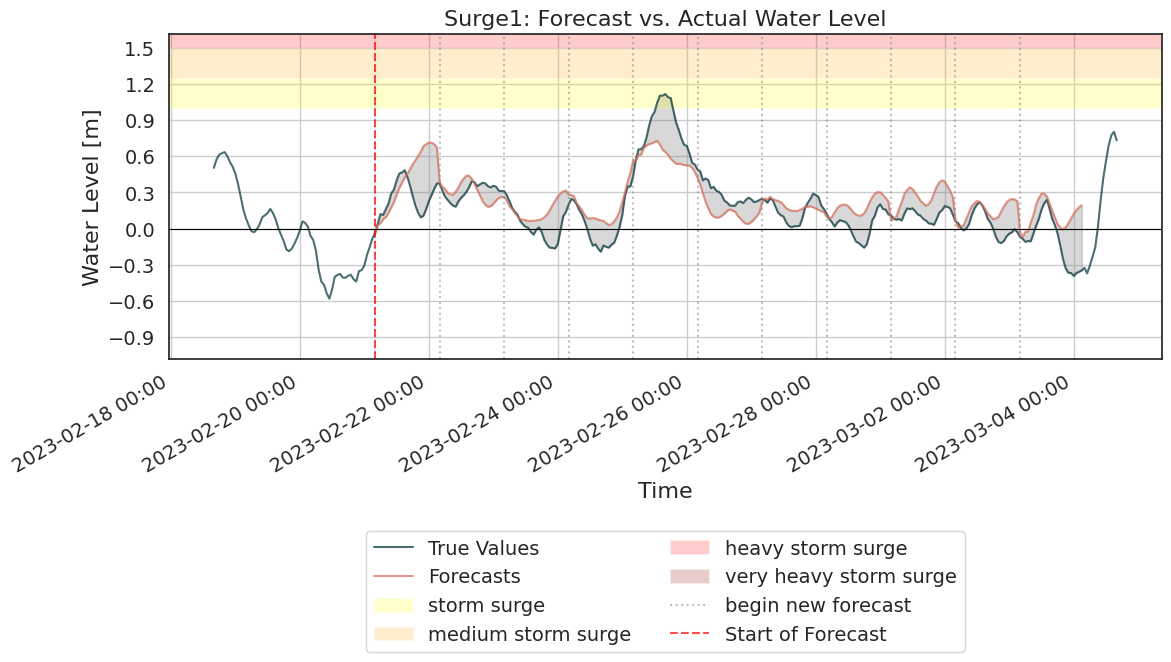

Fold: Surge2, Start: 2023-03-04 09:00:00, End: 2023-04-29 09:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0297 | Val Loss: 0.0144 | MSE Train: 0.0153 | MSE Val: 0.0144 | Time: 1.15s | Score Train: 0.4070 | Score Val: 0.3543 | 
| Epoch   2 | Train Loss: 0.0126 | Val Loss: 0.0110 | MSE Train: 0.0093 | MSE Val: 0.0110 | Time: 1.01s | Score Train: 0.3305 | Score Val: 0.2533 | 
| Epoch   3 | Train Loss: 0.0082 | Val Loss: 0.0077 | MSE Train: 0.0068 | MSE Val: 0.0077 | Time: 1.01s | Score Train: 0.2976 | Score Val: 0.1546 | 
| Epoch   4 | Train Loss: 0.0063 | Val Loss: 0.0062 | MSE Train

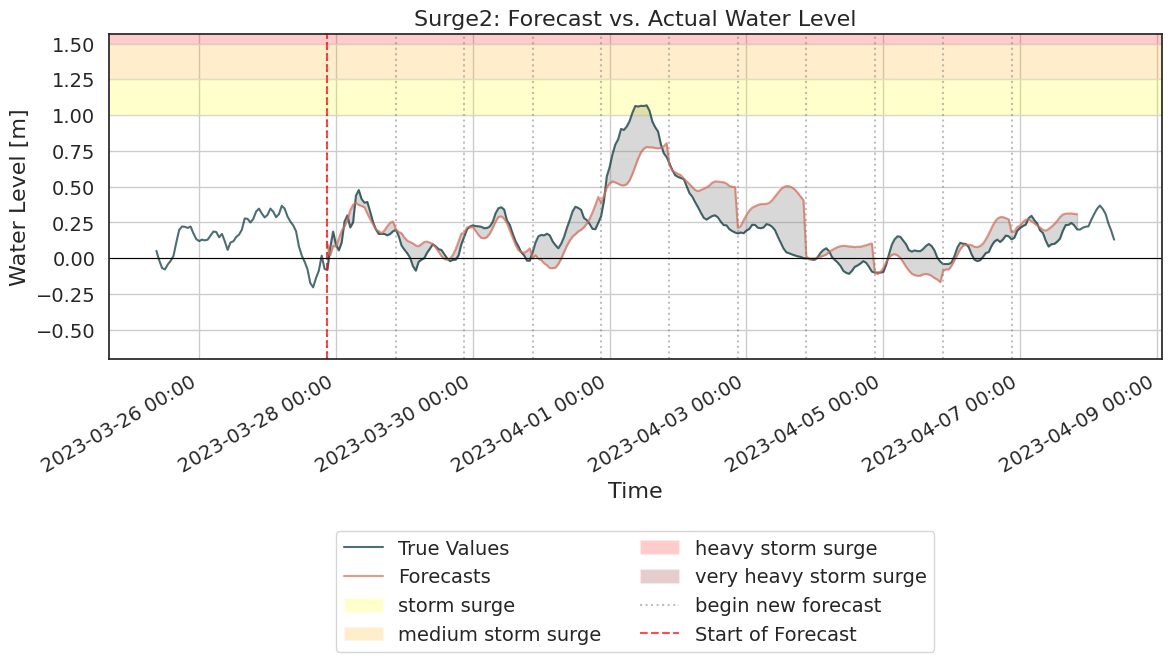

Fold: Surge3, Start: 2023-09-09 20:00:00, End: 2023-11-04 20:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0235 | Val Loss: 0.0268 | MSE Train: 0.0128 | MSE Val: 0.0268 | Time: 1.10s | Score Train: 0.1915 | Score Val: 0.3580 | 
| Epoch   2 | Train Loss: 0.0110 | Val Loss: 0.0169 | MSE Train: 0.0097 | MSE Val: 0.0169 | Time: 1.05s | Score Train: 0.1460 | Score Val: 0.3551 | 
| Epoch   3 | Train Loss: 0.0083 | Val Loss: 0.0134 | MSE Train: 0.0079 | MSE Val: 0.0134 | Time: 1.12s | Score Train: 0.0721 | Score Val: 0.3540 | 
| Epoch   4 | Train Loss: 0.0065 | Val Loss: 0.0106 | MSE Train

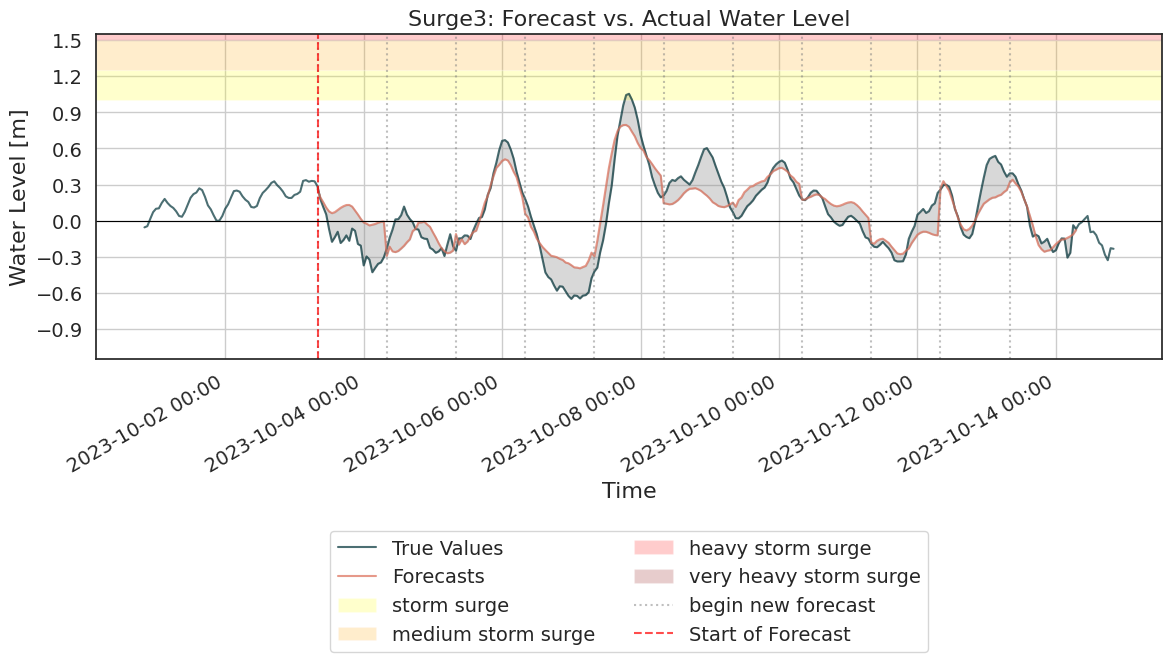

Fold: Surge4, Start: 2023-09-22 21:00:00, End: 2023-11-17 21:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0234 | Val Loss: 0.0596 | MSE Train: 0.0140 | MSE Val: 0.0596 | Time: 1.10s | Score Train: 0.2115 | Score Val: 0.2983 | 
| Epoch   2 | Train Loss: 0.0115 | Val Loss: 0.0355 | MSE Train: 0.0097 | MSE Val: 0.0355 | Time: 1.08s | Score Train: 0.0877 | Score Val: 0.2540 | 
| Epoch   3 | Train Loss: 0.0080 | Val Loss: 0.0243 | MSE Train: 0.0078 | MSE Val: 0.0243 | Time: 1.02s | Score Train: 0.0673 | Score Val: 0.2442 | 
| Epoch   4 | Train Loss: 0.0063 | Val Loss: 0.0193 | MSE Train

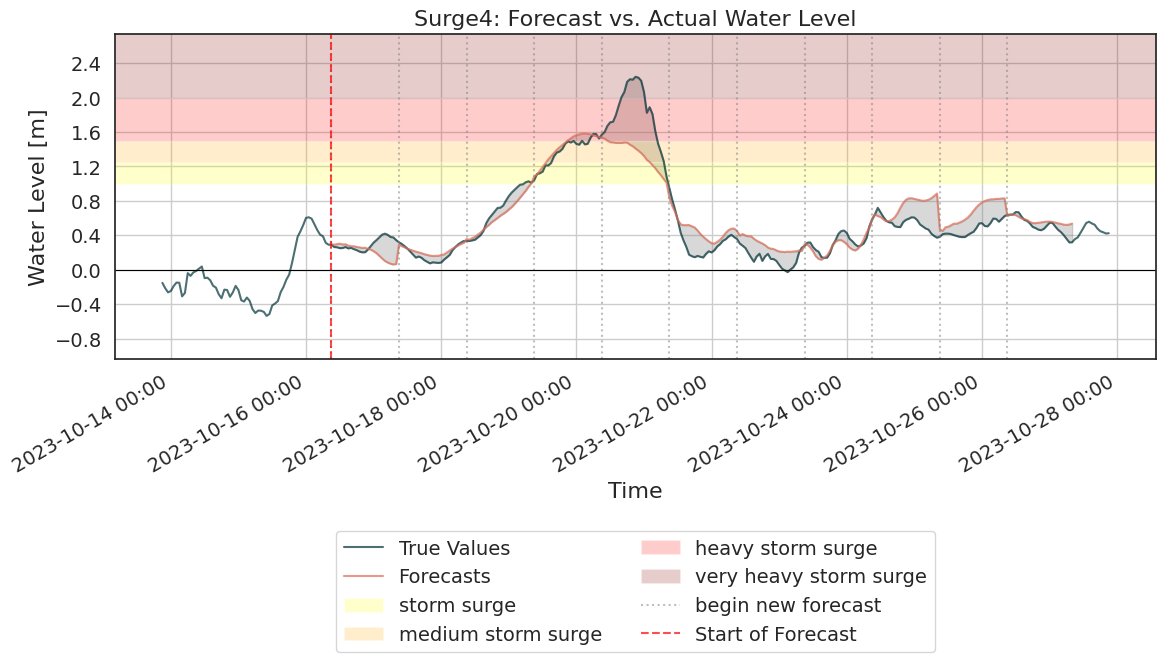

Fold: Surge5, Start: 2023-12-06 01:00:00, End: 2024-01-31 01:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0261 | Val Loss: 0.0450 | MSE Train: 0.0138 | MSE Val: 0.0450 | Time: 1.10s | Score Train: 0.4556 | Score Val: 0.3635 | 
| Epoch   2 | Train Loss: 0.0113 | Val Loss: 0.0169 | MSE Train: 0.0093 | MSE Val: 0.0169 | Time: 1.14s | Score Train: 0.2899 | Score Val: 0.0841 | 
| Epoch   3 | Train Loss: 0.0079 | Val Loss: 0.0133 | MSE Train: 0.0074 | MSE Val: 0.0133 | Time: 1.14s | Score Train: 0.2037 | Score Val: 0.0818 | 
| Epoch   4 | Train Loss: 0.0063 | Val Loss: 0.0119 | MSE Train

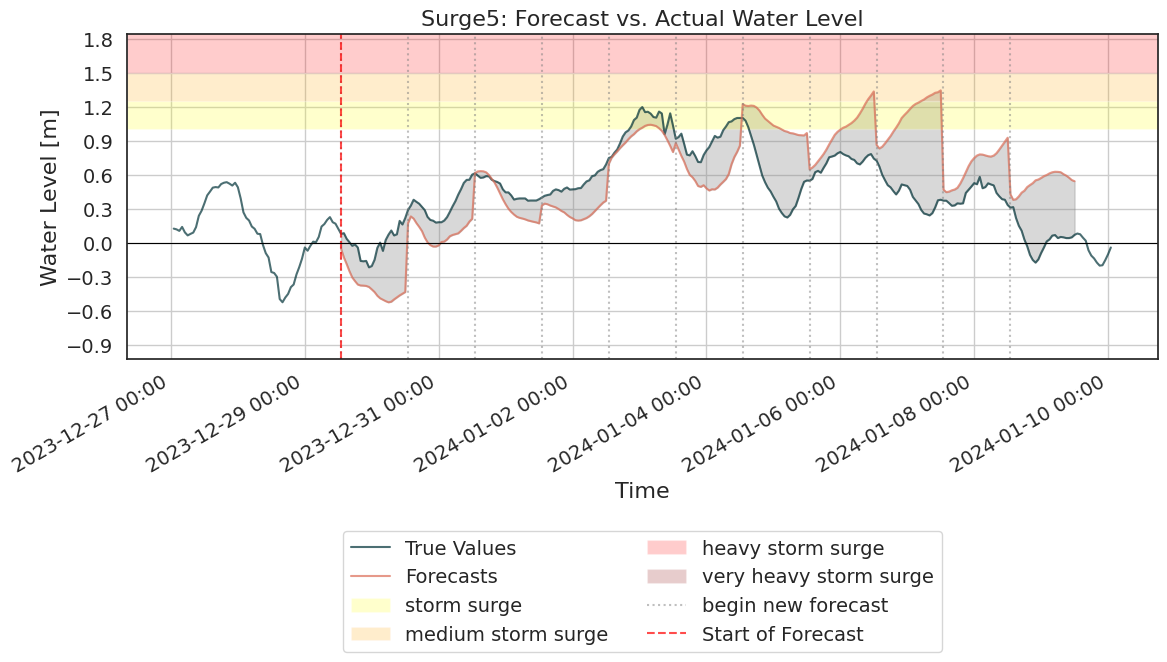

Fold: Surge6, Start: 2024-01-12 15:00:00, End: 2024-03-08 15:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0216 | Val Loss: 0.0131 | MSE Train: 0.0119 | MSE Val: 0.0131 | Time: 1.16s | Score Train: 0.3522 | Score Val: 0.2322 | 
| Epoch   2 | Train Loss: 0.0100 | Val Loss: 0.0145 | MSE Train: 0.0087 | MSE Val: 0.0145 | Time: 1.16s | Score Train: 0.1561 | Score Val: 0.0581 | 
| Epoch   3 | Train Loss: 0.0073 | Val Loss: 0.0116 | MSE Train: 0.0071 | MSE Val: 0.0116 | Time: 1.12s | Score Train: 0.0983 | Score Val: 0.0447 | 
| Epoch   4 | Train Loss: 0.0059 | Val Loss: 0.0101 | MSE Train

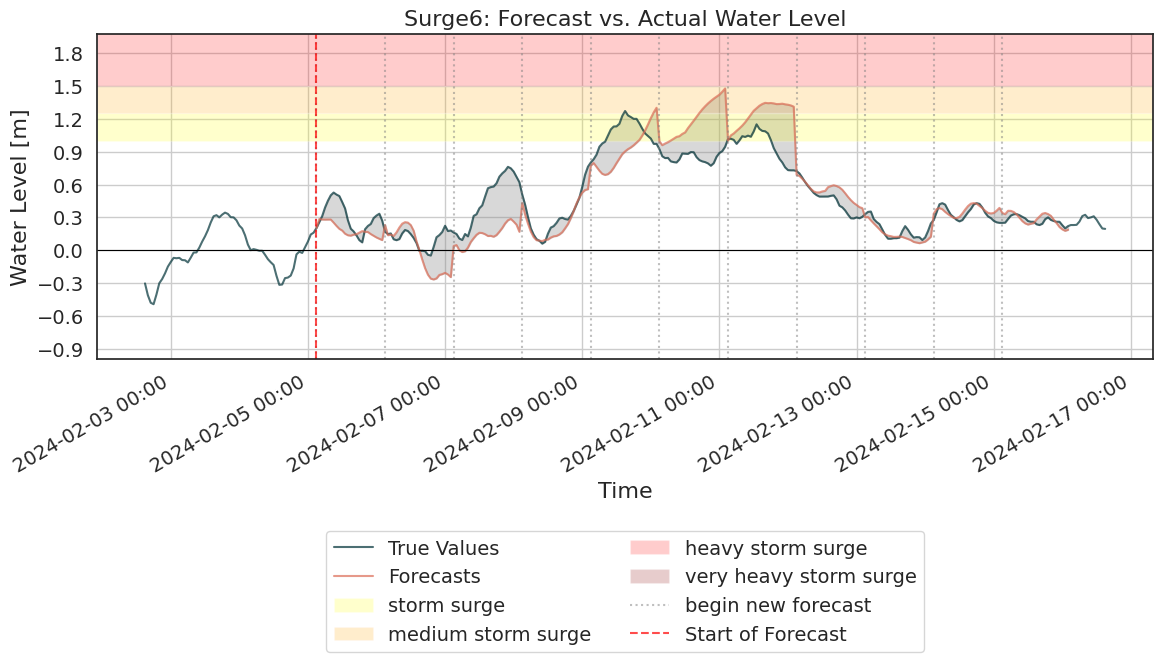

Fold: Surge7, Start: 2024-11-11 10:00:00, End: 2025-01-06 10:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0257 | Val Loss: 0.0200 | MSE Train: 0.0138 | MSE Val: 0.0200 | Time: 1.14s | Score Train: 0.4151 | Score Val: 0.3560 | 
| Epoch   2 | Train Loss: 0.0113 | Val Loss: 0.0137 | MSE Train: 0.0084 | MSE Val: 0.0137 | Time: 1.11s | Score Train: 0.3144 | Score Val: 0.3541 | 
| Epoch   3 | Train Loss: 0.0078 | Val Loss: 0.0085 | MSE Train: 0.0064 | MSE Val: 0.0085 | Time: 1.06s | Score Train: 0.2973 | Score Val: 0.3526 | 
| Epoch   4 | Train Loss: 0.0061 | Val Loss: 0.0073 | MSE Train

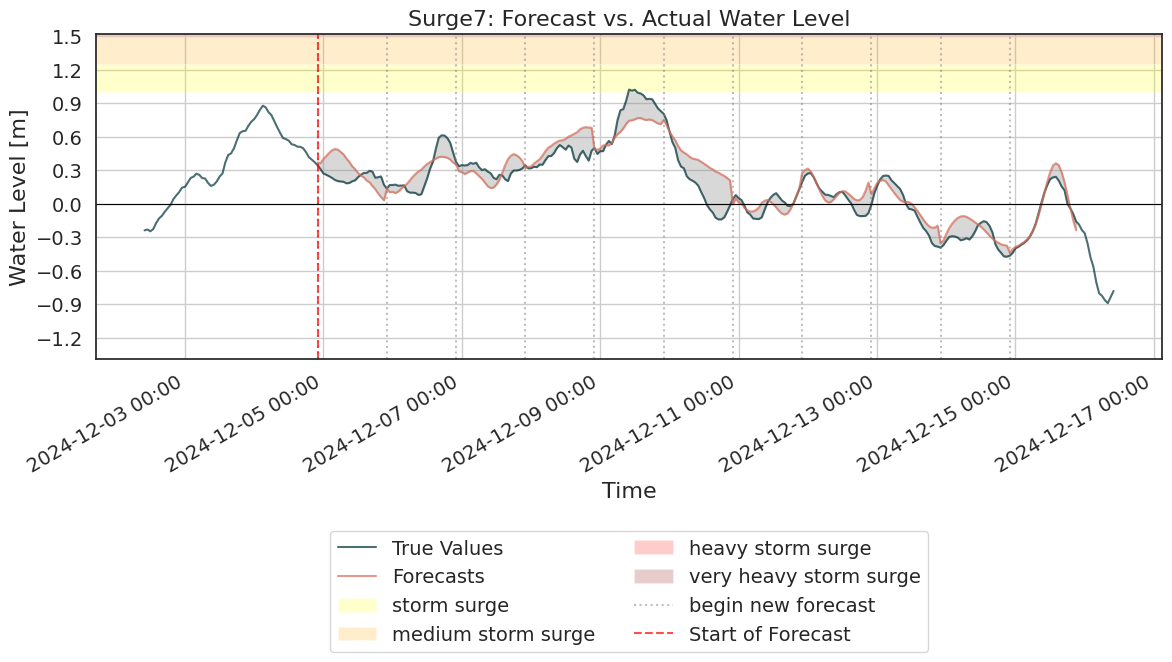

Fold: normal1, Start: 2023-06-03 14:00:00, End: 2023-07-29 14:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0321 | Val Loss: 0.0157 | MSE Train: 0.0173 | MSE Val: 0.0157 | Time: 1.18s | Score Train: 0.4558 | Score Val: 0.0047 | 
| Epoch   2 | Train Loss: 0.0140 | Val Loss: 0.0085 | MSE Train: 0.0099 | MSE Val: 0.0085 | Time: 1.04s | Score Train: 0.3310 | Score Val: 0.0026 | 
| Epoch   3 | Train Loss: 0.0088 | Val Loss: 0.0066 | MSE Train: 0.0071 | MSE Val: 0.0066 | Time: 1.02s | Score Train: 0.2182 | Score Val: 0.0020 | 
| Epoch   4 | Train Loss: 0.0066 | Val Loss: 0.0062 | MSE Trai

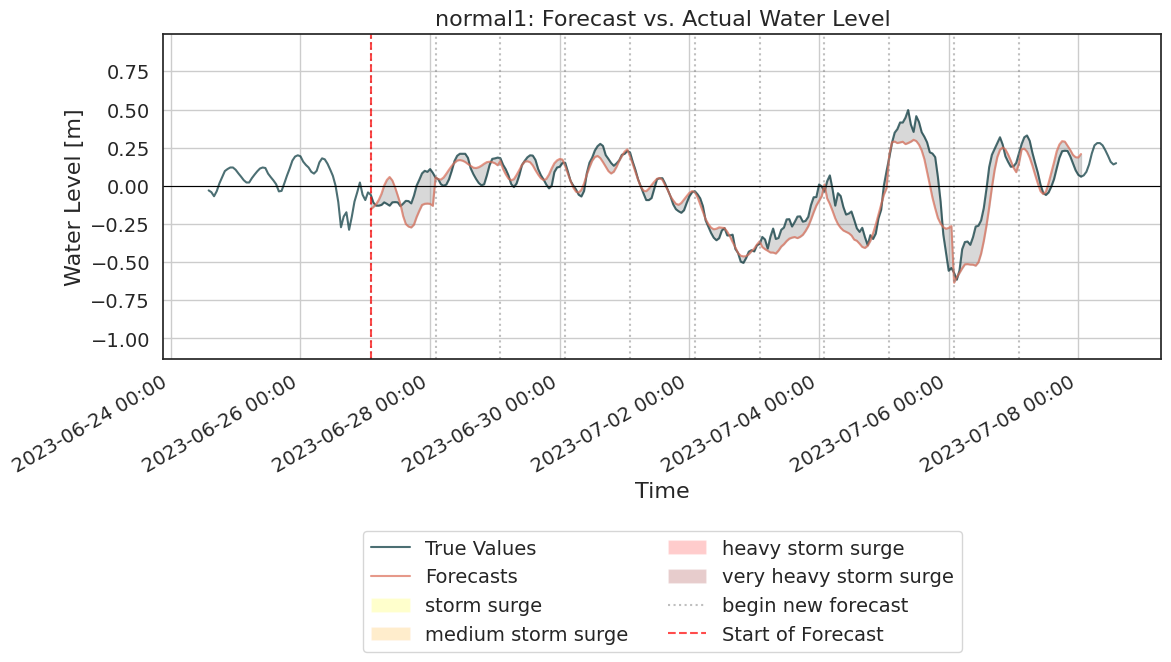

Fold: normal2, Start: 2024-03-04 18:00:00, End: 2024-04-29 18:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0261 | Val Loss: 0.0086 | MSE Train: 0.0125 | MSE Val: 0.0086 | Time: 1.04s | Score Train: 0.3480 | Score Val: 0.0026 | 
| Epoch   2 | Train Loss: 0.0112 | Val Loss: 0.0090 | MSE Train: 0.0089 | MSE Val: 0.0090 | Time: 1.01s | Score Train: 0.2766 | Score Val: 0.0027 | 
| Epoch   3 | Train Loss: 0.0081 | Val Loss: 0.0080 | MSE Train: 0.0086 | MSE Val: 0.0080 | Time: 1.02s | Score Train: 0.0853 | Score Val: 0.0024 | 
| Epoch   4 | Train Loss: 0.0072 | Val Loss: 0.0072 | MSE Trai

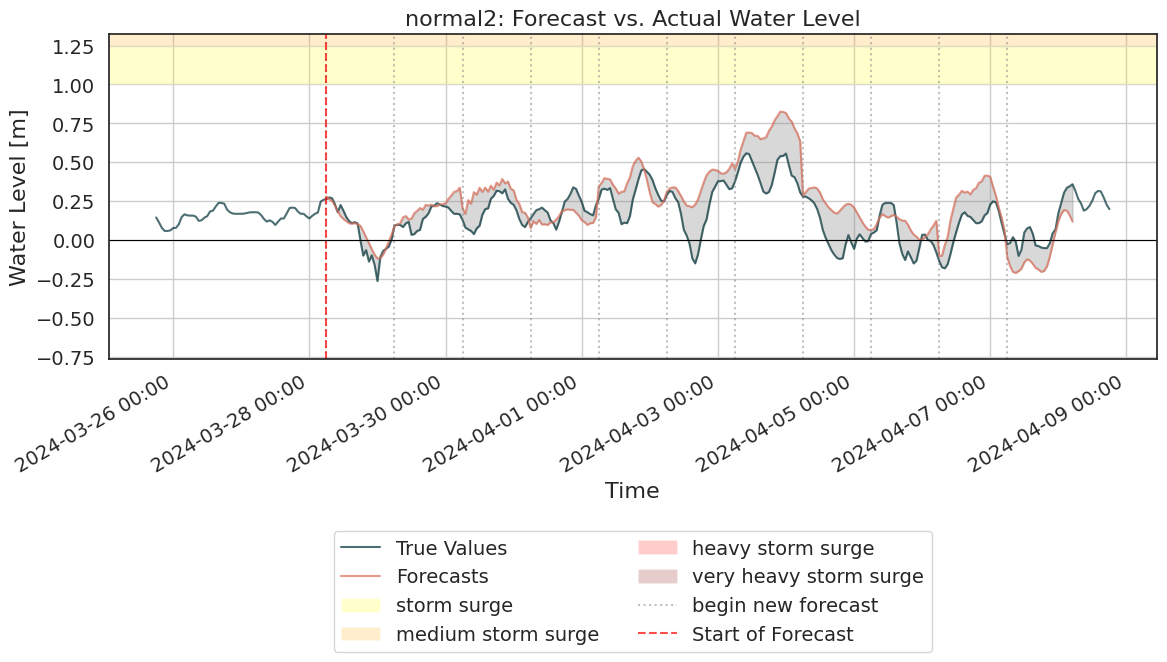

Fold: normal3, Start: 2024-12-04 12:00:00, End: 2025-01-29 12:00:00
Training data shape: (18792, 34), Validation data shape: (1345, 34)
X_train_tensor shape: torch.Size([18768, 24, 34]), y_train_tensor shape: torch.Size([18768, 1])
X_val_tensor shape: torch.Size([313, 24, 34]), y_val_tensor shape: torch.Size([313, 1])
LR: 0.001

Shape of X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

Reshaped X_train: torch.Size([18768, 24, 34]), y_train: torch.Size([18768, 1])

| Epoch   1 | Train Loss: 0.0278 | Val Loss: 0.0371 | MSE Train: 0.0138 | MSE Val: 0.0371 | Time: 2.16s | Score Train: 0.4130 | Score Val: 0.0111 | 
| Epoch   2 | Train Loss: 0.0114 | Val Loss: 0.0237 | MSE Train: 0.0084 | MSE Val: 0.0237 | Time: 2.07s | Score Train: 0.3062 | Score Val: 0.0071 | 
| Epoch   3 | Train Loss: 0.0085 | Val Loss: 0.0161 | MSE Train: 0.0069 | MSE Val: 0.0161 | Time: 1.65s | Score Train: 0.3201 | Score Val: 0.0048 | 
| Epoch   4 | Train Loss: 0.0067 | Val Loss: 0.0134 | MSE Trai

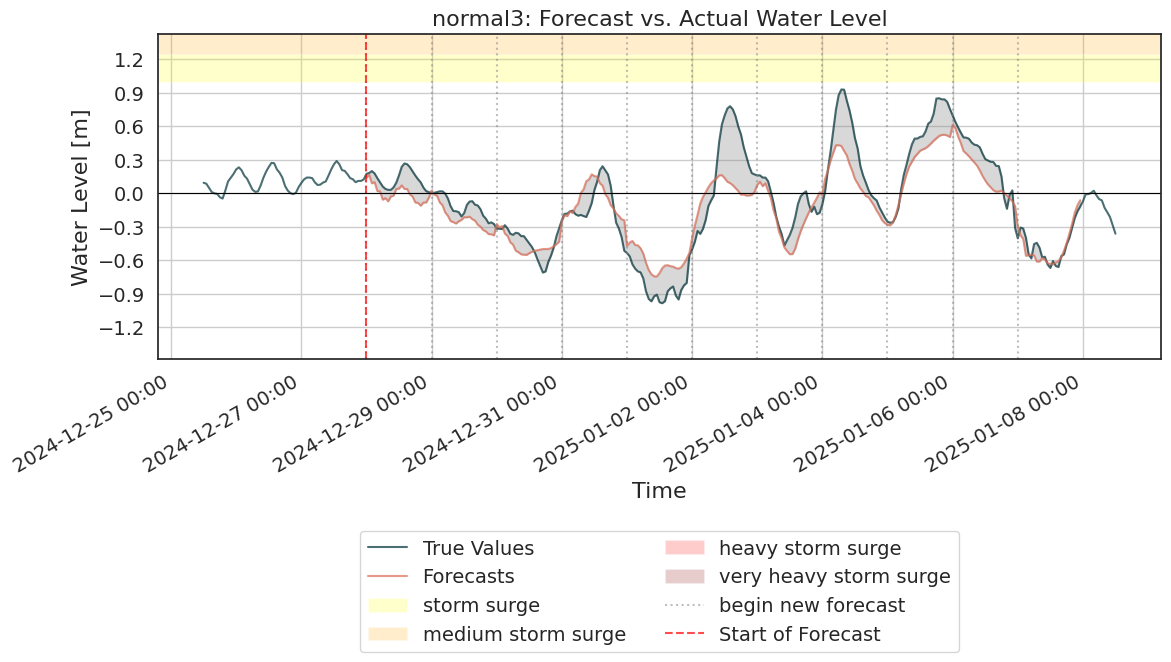

In [ ]:
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, recall_score, precision_score, f1_score, accuracy_score, mean_absolute_error
import matplotlib.dates as mdates

import torch
import torch.nn as nn

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class ClassicalMLPModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassicalMLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc2 = nn.Linear(input_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.out = nn.Linear(input_dim, output_dim)

        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)  # etwas stärkeres Dropout

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.out(x)
        return x


    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.forward(x)
        


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.6):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)

        # Output Layer
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Erwartet x in Form (batch_size, sequence_length, input_size)
        """
        # Initial states (h_0, c_0)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM Forward
        out, _ = self.lstm(x, (h_0, c_0))  # out: (batch, seq_len, hidden_size)

        # Nur letzter Zeitschritt zur Vorhersage
        out = out[:, -1, :]  # (batch, hidden_size)

        out = self.out(out)  # (batch, output_size)
        return out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.forward(x)



def recursive_forecast_from_model(
    model, X_future_df, y_history_df, scaler_X,
    sequence_length=24, horizon=24, device='cpu'):
    model.eval()
    preds = []

    # History für Lags
    extended_lag = (
        y_history_df['target']
        .dropna()
        .iloc[-2*sequence_length:]
        .copy()
    )
    feat_seq = X_future_df.iloc[:sequence_length].copy()
    #display(feat_seq.head())
    
    for step in range(horizon):
        # Lag‑Matrix bauen (n_shift = 1…sequence_length)
        lagged = pd.concat([
            extended_lag.shift(i+1).rename(f'lagged_{i+1}')
            for i in range(sequence_length)
        ], axis=1).dropna().iloc[-sequence_length:]
        lagged.index = feat_seq.index

        # Originalfeatures
        feats = feat_seq.loc[:, ~feat_seq.columns.str.startswith('lagged_')]

        # Zusammenfügen, Skalieren
        inp = pd.concat([feats, lagged], axis=1)
        if inp.shape[0] != sequence_length:
            raise RuntimeError(f"Unvollständige Sequenz bei Schritt {step}")

        # scaler_X muss genau auf diese Spaltenanzahl gefittet sein!
        X_scaled = scaler_X.transform(inp.values)

        X_tensor = torch.tensor(
            X_scaled.reshape(1, sequence_length, -1),
            dtype=torch.float32,
            device=device
        )

        # Vorhersage
        with torch.no_grad():
            y_pred = model.predict(X_tensor).cpu().numpy().item()
           
        # Zeitpunkt und Wert speichern
        t_next = X_future_df.index[sequence_length + step]
        preds.append((t_next, y_pred))

        # History updaten
        extended_lag = pd.concat([extended_lag, pd.Series([y_pred], index=[t_next])])
        extended_lag = extended_lag.iloc[-2*sequence_length:]

        # Feature‑Fenster verschieben
        new_feat = X_future_df.iloc[[sequence_length + step]]
        feat_seq = pd.concat([feat_seq.iloc[1:], new_feat])
        

    return pd.DataFrame(preds, columns=['time','forecast']).set_index('time') 


def custom_score_array(y_true, y_pred, bins=[1, 2.00], alpha=0.7):
    
    y_true_class = np.digitize(y_true, bins=bins)
    y_pred_class = np.digitize(y_pred, bins=bins)
    #print(f"y_true_class: {y_true_class}, \ny_pred_class: {y_pred_class}")
    recall = recall_score(y_true_class, y_pred_class, average="macro")
    
    mse = mean_squared_error(y_true, y_pred)
    return alpha * (1 - recall) + (1 - alpha) * mse

def calculate_class_scores(y_true, y_pred, bins=[1, 2.00]):

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_true_class = np.digitize(y_true, bins=bins)
    y_pred_class = np.digitize(y_pred, bins=bins)
    recall = recall_score(y_true_class, y_pred_class, average="macro")
    precision = precision_score(y_true_class, y_pred_class, average="macro")
    f1 = f1_score(y_true_class, y_pred_class, average="macro")
    accuracy = accuracy_score(y_true_class, y_pred_class)

    return recall, precision, f1, accuracy

# Cross-Validation Zeitpunkte
folds = {
    "Surge1": pd.Timestamp("2023-02-25 16:00:00"),
    "Surge2": pd.Timestamp("2023-04-01 09:00:00"),
    "Surge3": pd.Timestamp("2023-10-07 20:00:00"),
    "Surge4": pd.Timestamp("2023-10-20 21:00:00"),
    "Surge5": pd.Timestamp("2024-01-03 01:00:00"),
    "Surge6": pd.Timestamp("2024-02-09 15:00:00"),
    "Surge7": pd.Timestamp("2024-12-09 10:00:00"),
    "normal1": pd.Timestamp("2023-07-01 14:00:00"),
    "normal2": pd.Timestamp("2024-04-01 18:00:00"),
    "normal3": pd.Timestamp("2025-01-01 12:00:00"),
}


# 0: 0 + 24 + 24
# 1: 1 + 24 + 24


def create_sequences(X, y, seq_len=24):
    X_seqs, y_targets = [], []
    for i in range(len(X) - seq_len):
        X_seqs.append(X[i:i + seq_len])
        y_targets.append(y[i + seq_len])  # der nächste Zeitpunkt nach der Sequenz
    return np.array(X_seqs), np.array(y_targets)


# split data on folds
def cross_validation_loop(model_name, folds, X, y, time_delta, trial_params, trial:optuna.Trial=None, batch_size=32):
    result_df = pd.DataFrame()
    fold_results = []
    pred_times = []
    for fold_name, fold_time in folds.items():
        start_cutoff = fold_time - time_delta
        end_cutoff = fold_time + time_delta
        print(f"Fold: {fold_name}, Start: {start_cutoff}, End: {end_cutoff}")

        # Split data into training and validation sets
        X_train = X[(X.index < start_cutoff) | (X.index > end_cutoff)]
        y_train = y[(y.index < start_cutoff) | (y.index > end_cutoff)]
        X_val = X[(X.index >= start_cutoff) & (X.index <= end_cutoff)]
        y_val = y[(y.index >= start_cutoff) & (y.index <= end_cutoff)]

        

        # Create gap around the fold time
        gap = 168
        gap_start = fold_time -  pd.Timedelta(hours=gap)
        gap_end = fold_time + pd.Timedelta(hours=gap)

        X_val_df = X_val[(X_val.index >= gap_start) & (X_val.index <= gap_end)]
        y_val_df = y_val[(y_val.index >= gap_start) & (y_val.index <= gap_end)]

        # check if data contans NaN values
        if X_train.isnull().values.any() or y_train.isnull().values.any():
            print(f"NaN values found in training data for fold {fold_name}. Skipping this fold.")
            continue

        if X_val_df.isnull().values.any() or y_val_df.isnull().values.any():
            print(f"NaN values found in validation data for fold {fold_name}. Skipping this fold.")
            continue

        # create sequences
        

        print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")


        # Scale data
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_val_scaled = scaler_X.transform(X_val_df)

        # Aktuell:
        # X_train_scaled = scaler_X.fit_transform(X_train)
        # y_train = y_train.values.reshape(B_train, -1)

        # Neu:
        X_train_seqs, y_train_targets = create_sequences(X_train_scaled, y_train.values, seq_len=SEQUENCE_LENGTH)
        X_val_seqs, y_val_targets = create_sequences(X_val_scaled, y_val_df.values, seq_len=SEQUENCE_LENGTH)


        # convert to tensors
        X_train_tensor = torch.tensor(X_train_seqs, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_targets, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_seqs, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_targets, dtype=torch.float32)

        print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")
        print(f"X_val_tensor shape: {X_val_tensor.shape}, y_val_tensor shape: {y_val_tensor.shape}")

        # rehsape tensors to match input dimension



        lr = 0.001

        
                    
        print("LR:", lr)
        # model = ClassicalMLPModel(
        #     input_dim= X_train_tensor.shape[1] * X_train_tensor.shape[2],  # Number of features
        #     #hidden_dim=128,
        #     output_dim=1
        # )
        model = LSTMModel(
            input_size=X_train_tensor.shape[2],  # Number of features
            hidden_size=128,  # Hidden size for LSTM
            output_size=1,  # Output size (1 for regression)
            num_layers=1,  # Number of LSTM layers
            dropout=0.1  # Dropout rate
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

        best_model = training_ConvLSTM_Regression_Classification_pca(
            model,
            X_train=X_train_tensor,  # Reshape to match input dimension
            y_train=y_train_tensor,
            X_val=X_val_tensor,  # Reshape to match input dimension
            y_val=y_val_tensor,
            epochs=1000,
            batch_size=batch_size,
            optimizer=optimizer,
            writer=None,
            verbose=True,
            log_tensorboard=False,
            patience=10,
            trial=trial,
            use_amp=False,
            classification_loss=False,
            reduce_lr_patience=10,
        )
        
        

        best_model.to("cpu")
        time_pre_start = time.time()
        predictions = best_model.predict(X_val_tensor)
        time_pre_end = time.time()
        avg_time = (time_pre_end - time_pre_start) / X_val_tensor.shape[0]
        
        print(f"Predictions shape: {predictions.shape}, y_val_tensor shape: {y_val_tensor.shape}")



        first_X = X_val_df.index.min() + pd.Timedelta(hours=SEQUENCE_LENGTH)
        last_X  = X_val_df.index.max() - pd.Timedelta(hours=HORIZON)
        first_y = y_val_df.index.min() + pd.Timedelta(hours=2*SEQUENCE_LENGTH)

        first_valid_start = max(first_X, first_y)
        last_valid_start  = last_X
        print(f"Zulässige Starts: {first_valid_start} … {last_valid_start}")

        desired_start = first_valid_start + pd.Timedelta(hours=12)
        print(f"Start: {desired_start}")
        #pd.Timestamp("2022-12-07 00:00:00")

        if not (first_valid_start <= desired_start <= last_valid_start):
            raise ValueError(f"Ungültiger Start {desired_start}. "
                            f"Erlaubt: {first_valid_start} bis {last_valid_start}")

        
        # Grund-Starts (shift 0):
        all_starts = pd.date_range(
            start=desired_start,
            end=last_valid_start,
            freq=f'{HORIZON}H'
        )

        dfs_per_shift = []

        # Berechne maximum_shift
        upper = (X_val_df.index.max()
                - desired_start
                - pd.Timedelta(hours=HORIZON-1))
        max_shift_hours = int(upper.total_seconds() // 3600)
        print("Maximaler Shift (in Stunden):", max_shift_hours)

        #  Wähle Schrittweite
        step = 1

        # Iteriere über alle zulässigen Shifts
        for start_shift in range(0, max_shift_hours+1, step):
            shifted_starts = all_starts + pd.Timedelta(hours=start_shift)

            # nur die Starts behalten, deren Fenster vollständig im X_val_df liegen
            valid_starts = []
            for current_start in shifted_starts:
                window_start = current_start - pd.Timedelta(hours=SEQUENCE_LENGTH)
                window_end   = current_start + pd.Timedelta(hours=HORIZON-1)

                if (window_start >= X_val_df.index.min() and
                    window_end   <= X_val_df.index.max()):
                    valid_starts.append(current_start)

            # Forecasts für alle gültigen Starts sammeln
            all_forecasts = []
            for current_start in valid_starts:
                y_hist = y_val_df.loc[:current_start].copy()
                window_start = current_start - pd.Timedelta(hours=SEQUENCE_LENGTH)
                window_end   = current_start + pd.Timedelta(hours=HORIZON-1)
                X_win = X_val_df.loc[window_start:window_end].copy()

                df_fc = recursive_forecast_from_model(
                    model=best_model,
                    X_future_df=X_win,
                    y_history_df=y_hist,
                    scaler_X=scaler_X,
                    sequence_length=SEQUENCE_LENGTH,
                    horizon=HORIZON,
                    device='cpu'
                )
                all_forecasts.append(df_fc['forecast'])

            # zu DataFrame zusammensetzen und Spalte umbenennen
            df_shift = pd.concat(all_forecasts).to_frame(name=f'forecast{start_shift}')
            dfs_per_shift.append(df_shift)

        # alle Shift‑DFs nebeneinander mergen
        df_all = pd.concat(dfs_per_shift, axis=1)

        #display(df_all.head())
        
        for i, col in enumerate(df_all.columns):
            df_compare = pd.concat([df_all[col], y_val_df], axis=1, join='inner').rename(columns={col: 'y_pred', 'target': 'y_true'}).dropna()
            
            y_pred = df_compare['y_pred'].values
            y_true = df_compare['y_true'].values




            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            recall, precision, f1, accuracy = calculate_class_scores(y_true, y_pred, bins=[1, 1.25, 1.5, 2.0])
            custom_score_value = custom_score_array(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)





            # --- Visualisierung ---
            if i <= 0:

                y_true = y_val_df['target']
                y_pred = df_all[col]

                
                

                # Highlight storm surge classes with colored bands
                flood_levels = [
                    (1.0, 1.25, 'yellow', 'storm surge'),
                    (1.25, 1.5, 'orange', 'medium storm surge'),
                    (1.5, 2.0, 'red', 'heavy storm surge'),
                    (2.0, 3.5, 'darkred', 'very heavy storm surge'),
                ]

                from matplotlib.figure import Figure
                from matplotlib.axes import Axes

                fig: Figure
                ax: Axes
                fig, ax = plt.subplots(figsize=(12, 8))
                ax.plot(y_true, label='True Values', color=TRUE_COLOR, alpha=0.7)
                ax.plot(y_pred, label='Forecasts', color=PRED_COLOR, alpha=0.7)

                # If confidence intervals are not requested, we can still plot the forecast area
                df = pd.concat([
                    y_true.rename("true"),
                    y_pred.rename("pred")
                ], axis=1).dropna()  # nur Zeitpunkte behalten, wo beide existieren

                ax.fill_between(df.index, df["true"], df["pred"], color="grey", alpha=0.3)
                
                for y0, y1, color, label in flood_levels:
                    ax.axhspan(y0, y1, facecolor=color, alpha=0.2, label=label)

                for i, ts in enumerate(all_starts):
                    label = 'begin new forecast' if i == 0 else None
                    ax.axvline(ts, color='gray', linestyle=':', alpha=0.5, label=label)

                ax.axvline(y_pred.dropna().index[0], color='red', linestyle='--', alpha=0.7, label='Start of Forecast')

                ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

                ax.set_xlabel("Time")
                ax.set_ylabel("Water Level [m]")
                ax.set_title(f"{fold_name}: Forecast vs. Actual Water Level")
                ax.legend(
                    loc="upper center",        # oberhalb zentriert
                    bbox_to_anchor=(0.5, -0.5), # Position unterhalb der Achse
                    ncol=2                     # mehrere Spalten für Übersichtlichkeit
                )

                y_min = min(y_true.min(), y_pred.min())
                y_max = max(y_true.max(), y_pred.max())
                ax.set_ylim(y_min - 0.5, y_max + 0.5)

                ax.yaxis.set_major_locator(plt.MaxNLocator(10)) # make y-axis labels readable
                ax.xaxis.set_major_locator(plt.MaxNLocator(10)) # make x-axis labels readable
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
                fig.autofmt_xdate()
                ax.grid(True)
                plt.tight_layout()
                plt.savefig(f"../thesis_plots/{trial_name}_DL_{model_name}_fold_{fold_name}.png", dpi=300)
                plt.show()

                num_params = count_parameters(best_model)


                result_df = pd.concat([
                result_df,
                pd.DataFrame({
                    "fold": [fold_name],
                    "MSE": [round(mse,3)],
                    "RMSE": [round(rmse,3)],
                    "MAE": [round(mae,3)],
                    "Recall": [round(recall,3)],
                    "Precision": [round(precision,3)],
                    "F1": [round(f1,3)],
                    "Accuracy": [round(accuracy,3)],
                    "Custom Score": [round(custom_score_value,3)],
                    "Time Prediction [s]": [avg_time],
                    "Num Parameters": [num_params],
                })
            ], ignore_index=True) 

            # Annahme: reg_out und y_test haben shape (961, 24)
            # plt.figure(figsize=(15, 6))

            # plt.plot(predictions.cpu().numpy(), label='Predicted', color='blue', alpha=0.5)
            # plt.plot(y_val_tensor.cpu().numpy(), label='True', color='orange', alpha=0.5)

            # plt.xlabel("Time Steps")
            # plt.ylabel("Value")
            # plt.title("Predicted vs. True Values (every 24h block) at learning rate " + str(lr))
            # plt.legend(['Predicted', 'True'])
            # plt.show()
        
    return best_model, X_val_df, y_val_df, scaler_X, result_df, df_all
        

best_model, X_val_df, y_val_df, scaler_X , result_df, df_all= cross_validation_loop(
                                    model_name="LSTM",
                                    folds=folds,
                                    X=df_X,
                                    y=df_y,
                                    time_delta=pd.Timedelta(hours=168 * 4),
                                    trial_params=None,
                                    trial=None,
                                    batch_size=512
                                )


,fold,MSE,RMSE,MAE,Recall,Precision,F1,Accuracy,Custom Score,Time Prediction [s],Num Parameters
0,Surge1,0.039,0.197,0.152,0.500,0.489,0.494,0.977,0.362,0.000008,84097
1,Surge2,0.026,0.161,0.120,0.500,0.487,0.493,0.973,0.358,0.000008,84097
2,Surge3,0.027,0.165,0.131,0.500,0.494,0.497,0.989,0.358,0.000007,84097
3,Surge4,0.046,0.214,0.143,0.483,0.454,0.467,0.879,0.258,0.000008,84097
4,Surge5,0.160,0.400,0.327,0.431,0.402,0.407,0.799,0.296,0.000008,84097
5,Surge6,0.051,0.226,0.159,0.433,0.497,0.462,0.814,0.186,0.000007,84097
6,Surge7,0.019,0.139,0.107,0.500,0.494,0.497,0.989,0.356,0.000008,84097
7,normal1,0.011,0.104,0.078,1.000,1.000,1.000,1.000,0.003,0.000007,84097
8,normal2,0.025,0.157,0.126,1.000,1.000,1.000,1.000,0.007,0.000007,84097
9,normal3,0.042,0.204,0.157,1.000,1.000,1.000,1.000,0.012,0.000007,84097


,fold,MSE,RMSE,MAE,Recall,Precision,F1,Accuracy,Custom Score,Time Prediction [s],Num Parameters
0,Surge1,0.039,0.197,0.152,0.500,0.489,0.494,0.977,0.362,0.0,84097.0
1,Surge2,0.026,0.161,0.120,0.500,0.487,0.493,0.973,0.358,0.0,84097.0
2,Surge3,0.027,0.165,0.131,0.500,0.494,0.497,0.989,0.358,0.0,84097.0
3,Surge4,0.046,0.214,0.143,0.483,0.454,0.467,0.879,0.258,0.0,84097.0
4,Surge5,0.160,0.400,0.327,0.431,0.402,0.407,0.799,0.296,0.0,84097.0
5,Surge6,0.051,0.226,0.159,0.433,0.497,0.462,0.814,0.186,0.0,84097.0
6,Surge7,0.019,0.139,0.107,0.500,0.494,0.497,0.989,0.356,0.0,84097.0
7,normal1,0.011,0.104,0.078,1.000,1.000,1.000,1.000,0.003,0.0,84097.0
8,normal2,0.025,0.157,0.126,1.000,1.000,1.000,1.000,0.007,0.0,84097.0
9,normal3,0.042,0.204,0.157,1.000,1.000,1.000,1.000,0.012,0.0,84097.0


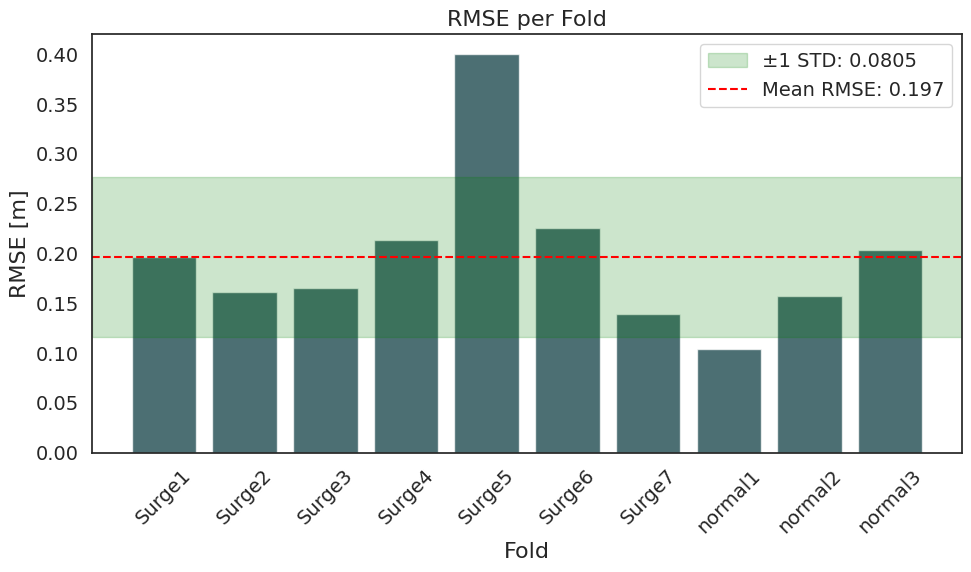

,MSE,RMSE,MAE,Recall,Precision,F1,Accuracy,Custom Score,Time Prediction [s],Num Parameters
0,0.0446,0.1967,0.15,0.6347,0.6317,0.6317,0.942,0.2196,0.00001,84097.0


In [15]:
display(result_df)
df_grouped = result_df.groupby('fold').mean(numeric_only=True).round(3).reset_index()
display(df_grouped)
# plot barplot
fig = plt.figure(figsize=(10, 6))
plt.bar(df_grouped['fold'], df_grouped['RMSE'], color=TRUE_COLOR, alpha=0.7)
rmse = df_grouped['RMSE'].mean()
std_value = result_df['RMSE'].std()

plt.axhspan(rmse - std_value, rmse + std_value, 
            color='green', alpha=0.2, 
            label=f'±1 STD: {std_value:.4f}')
plt.axhline(rmse, color='red', linestyle='--', label=f'Mean RMSE: {rmse:.3f}')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('RMSE [m]')
plt.title('RMSE per Fold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"../thesis_plots/{trial_name}_DL_LSTM_RMSE_per_fold.png", dpi=300)
plt.show()


df_save=result_df.mean(numeric_only=True).round(5).to_frame().T
display(df_save)
df_save.to_csv(f"../thesis_plots/{trial_name}_DL_LSTM_results.csv", index=False)


In [16]:
dd

NameError: name 'dd' is not defined